In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("nitishabharathi/cert-insider-threat")

print("Path to dataset files:", path)
files = os.listdir(path)
df = pd.read_csv(os.path.join(path, "email.csv"))

Path to dataset files: C:\Users\pc\.cache\kagglehub\datasets\nitishabharathi\cert-insider-threat\versions\1


In [3]:
# Select only 20000 samples
df["Threat"] = np.random.choice(["Yes", "No"], size=len(df), p=[0.5, 0.5])
df["Threat"] = df["Threat"].map({"Yes": 1, "No": 0})
df = df.sample(n=500, random_state=42)
df.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,Threat
1375085,{X9O7-L3NQ83SH-7546ROCM},09/08/2010 09:48:21,HWH0646,PC-8087,Ursa.Britanney.Frederick@dtaa.com;Abel.Adam.Mo...,NaN,NaN,Hadley.Willa.Hill@dtaa.com,53433,5,emotion rose better presented adult potts 12 w...,1
1760687,{N4J5-H0DM81GR-0636AXZX},11/18/2010 11:40:48,EMW0772,PC-6035,Butler-Serina@yahoo.com;Vance-Quintessa@netzer...,NaN,NaN,Walton-Elvis@cox.net,23746,0,became involvement protested him recounted jun...,0
489761,{T3T3-X0QU63SN-9148FQEX},03/29/2010 14:40:35,HAD0246,PC-0926,TEB582@verizon.net,NaN,NaN,HAD172@optonline.net,20984,0,security decide relaxed 2 considering removal ...,1
670295,{S1I7-L4JZ84KI-7061AWTL},04/30/2010 10:57:44,ASB0796,PC-1130,Tobias.Lucas.Morin@dtaa.com;Sonya.Samantha.Hah...,NaN,NaN,Ayanna.Sylvia.Blankenship@dtaa.com,33996,0,stripped neck again former ending while useful...,0
2611719,{C8B5-Q0BW49BI-1420XVWZ},05/12/2011 11:45:23,HCW0419,PC-3772,Herman.Ian.Abbott@dtaa.com,NaN,Hermione.Casey.Witt@dtaa.com,Hermione.Casey.Witt@dtaa.com,37670,0,ended 40 large early relish mid made arrested ...,0


In [4]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [5]:
# Extract features & target
X = df.drop(columns=['Threat'])
y = df['Threat']

In [9]:
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

In [10]:
# Preprocessing techniques to test
preprocessing_methods = {
    "Baseline": lambda X, y: (X, y),
    "One-Hot Encoding": lambda X, y: (np.hstack((OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(X[categorical_cols]), X.drop(columns=categorical_cols).values)), y),
    "Standardization": lambda X, y: (StandardScaler().fit_transform(X), y),
    "PCA": lambda X, y: (PCA(n_components=0.95).fit_transform(StandardScaler().fit_transform(X)), y),
    "SMOTE": lambda X, y: SMOTE(random_state=42).fit_resample(X, y)
}



In [11]:
accuracy_results = {}

In [15]:
for method, preprocess in preprocessing_methods.items():
    print(f"Applying {method}...")
    X_processed, y_processed = preprocess(X, y)
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)
    
    # Convert data to PyTorch tensors
    X_train = np.array(X_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy().astype(np.float32))
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy().astype(np.float32))

    # Create DataLoader
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Define Neural Network model
    class NeuralNet(nn.Module):
        def __init__(self, input_size):
            super(NeuralNet, self).__init__()
            self.fc1 = nn.Linear(input_size, 64)
            self.relu = nn.ReLU()
            self.dropout1 = nn.Dropout(0.3)
            self.fc2 = nn.Linear(64, 32)
            self.dropout2 = nn.Dropout(0.2)
            self.fc3 = nn.Linear(32, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout1(x)
            x = self.relu(self.fc2(x))
            x = self.dropout2(x)
            x = self.sigmoid(self.fc3(x))
            return x

    # Initialize model, loss function, and optimizer
    model = NeuralNet(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 10
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze()
        y_pred = (y_pred > 0.5).float()
        accuracy = (y_pred == y_test_tensor).float().mean().item()
        accuracy_results[method] = accuracy
        print(f"{method} Test Accuracy: {accuracy:.4f}")
    

Applying Baseline...
Baseline Test Accuracy: 0.4900
Applying One-Hot Encoding...
One-Hot Encoding Test Accuracy: 0.4700
Applying Standardization...
Standardization Test Accuracy: 0.4900
Applying PCA...
PCA Test Accuracy: 0.4400
Applying SMOTE...
SMOTE Test Accuracy: 0.5133


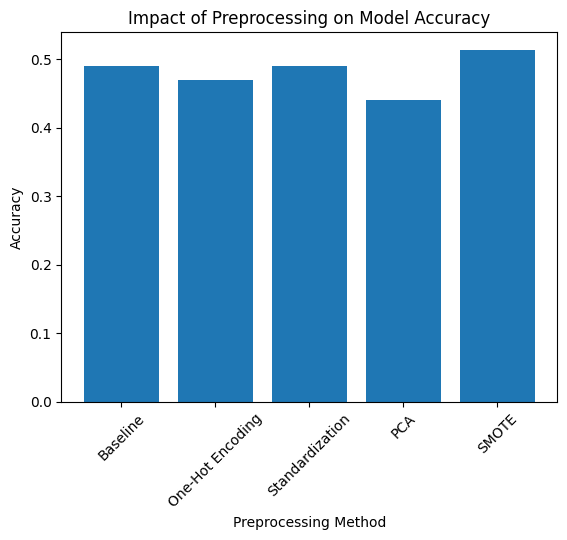

In [16]:
# Plot results
plt.bar(accuracy_results.keys(), accuracy_results.values())
plt.xlabel("Preprocessing Method")
plt.ylabel("Accuracy")
plt.title("Impact of Preprocessing on Model Accuracy")
plt.xticks(rotation=45)
plt.show()


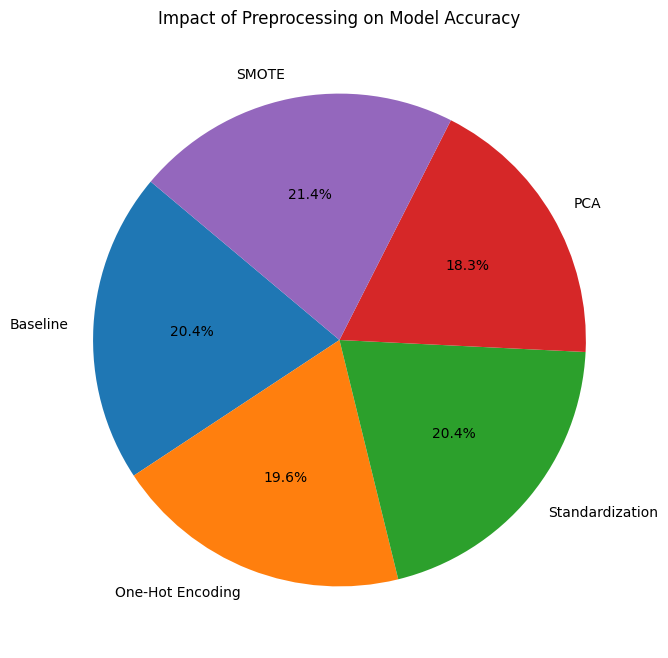

In [17]:
plt.figure(figsize=(8, 8))
plt.pie(accuracy_results.values(), labels=accuracy_results.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Impact of Preprocessing on Model Accuracy")
plt.show()
